## Cellular Automata Model for Traffic

Layout of CA:

- Each section of each lane is a cell

Model assumptions:
- .4 miles between 14th and Peachtree to 10th and Peachtree travelling southbound (google maps)
- Average car is 16ft long (https://www.quora.com/What-is-the-average-length-of-a-car-in-feet)
- typically space of a car between each car, so each cell is 16ft * 2 = 32 ft long
- .4 miles = 2112 ft
- 2112 ft / 32 ft = 66 cells
- 2 lane road
- road model is therefore (66 x 2)


In [1]:
import numpy as np
import matplotlib.pyplot as plot
import random

In [2]:
ROAD_SIZE = (66, 2)

def init_road_vels():
    R = np.zeros(ROAD_SIZE)
    V = np.full(ROAD_SIZE, -1)
    
    return R, V

def show_road(R, time_no):
    args = {}
    args['cmap'] = 'jet'
    args['vmin'] = 0
    args['vmax'] = 1
    plot.figure(figsize=(8, 8))
    plot.matshow(R, fignum=1, **args)
    plot.xlabel('lanes')
    plot.ylabel('Peachtree southbound')
    # plt.colorbar()
    
    plot.title("Road at time {}".format(time_no))
    pass

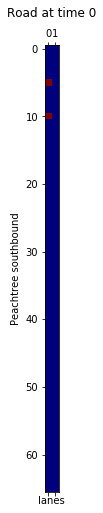

In [3]:
R = np.zeros(ROAD_SIZE)
R[5, 0] = 12
R[10, 0] = 20

show_road(R, 0)

### Velocities

We'll keep track of velocities in a similarly shaped array. 

- A velocitiy of -1 means unoccupied
- A velocity > -1 represents how many squares this car will travel in a timestep 


We'll use timesteps $t$ = 1 sec. For a car going 35mph = 51.3fps = 1.6 cells / t. Since we need integers we'll round this up to 2 cells / t (~43.6 mph)

In [4]:
V = np.full(ROAD_SIZE, -1)

### Movement 

We'll model movement stochastically. Each car has a probability of going straight, left or right.

Using the south bound NGSIM data, lane changes have the following probabilities

- P(straight):  0.9920035176341865
- P(left):  0.003977789821357357
- P(right):  0.004018692544456147

To simplify this, I'll use the following values

- P(straight):  0.992
- P(left):  0.004
- P(right):  0.004

In [5]:
def get_rand_dir():
    r = random.random()
    
    # right
    if r > .996:
        return 1
    
    # left
    if r > .992:
        return -1

    # straight
    return 0

In [6]:
def step(R, V, lights):
    R_new = np.zeros(R.shape)
    V_new = np.full(V.shape, -1)
    cars_leaving = []
    
    cars = (R >= 1)
    
    # 10th, 11th, 12th, and 14th st
    LIGHT_ROWS = [65, 49, 33, 0]
    
    # go backwards since cars moving forward
    for i in range(R.shape[0] -1, -1, -1):
        for j in range(R.shape[1]):    
            if cars[i, j]:
                car_id = R[i, j].astype(int)
                # print("there's a car in {}, {} with id: {}".format(i, j, car_id))
                # print('Carid: ', car_id)
                d = get_rand_dir()
                
                new_lane = j + d
                
                # don't actually change lane if on edge
                if new_lane > 1 or new_lane < 0:
                    new_lane -= d
                
                new_block = i + V[i, j]
                
                # check lights
                for light_i, light_row in enumerate(LIGHT_ROWS):
                    if not lights[light_i] and i <= light_row and new_block > light_row:
                        # Want to cross intersection but light is 0
                        new_block = light_row
                        break
                 
                # See if car has left corridor
                if new_block >= R.shape[0]:
                    cars_leaving.append(car_id)
                    new_block = None
                else:
                    # make sure not occupied, else dont move
                    while R_new[new_block, new_lane] and new_block > i:
                        new_block -= 1
                
                # couldnt move
                if new_block == i:
                    new_block = i
                    new_lane = j
                
                if new_block:
                    R_new[new_block, new_lane] = car_id
                    V_new[new_block, new_lane] = V[i, j]
        
    return R_new, V_new, cars_leaving
    

In [7]:
R, V = init_road_vels()
R[0, 0] = 1
V[0, 0] = 1

### Run basic sim

In [8]:
R, V = init_road_vels()
R[0, 0] = 1
R[0, 1] = 1
V[0, 0] = 2
V[0, 1] = 2


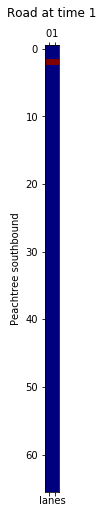

In [9]:
R, V, _ = step(R, V, [1,1,1,1])
show_road(R, 1)

### Sample to get entering cars

Sample from lognorm distribution to see when next car will enter simulation. Parameters generated empircally in `Background Distribution` notebook

In [10]:
import scipy.stats as ss

In [11]:
def get_next_entry_time_14th():
    log_dist = ss.lognorm
    rand = log_dist.rvs(1.123494632217069, loc=-0.1308024415404237, scale=2.222162369513514, size=1)[0]
    return int(rand)

def get_next_entry_time_11th():
    log_dist = ss.lognorm
    rand = log_dist.rvs(1.5234191072345973, loc=1.9716462121837928, scale=7.605110207945611, size=1)[0]
    
    return int(rand)

In [12]:
get_next_entry_time_14th()

0

### Test distributions


In [13]:
arr_11 = []
for _ in range(10):
    num_cars_11 = 0
    count_11 = 0

    while count_11 < 900:
        r = get_next_entry_time_11th()
        count_11 += r
        num_cars_11 += 1
    arr_11.append(num_cars_11)

In [14]:
np.average(arr_11)

40.2

In [15]:
arr_14 = []
for _ in range(10):
    num_cars_14 = 0
    count_14 = 0

    while count_14 < 900:
        r = get_next_entry_time_14th()
        count_14 += r
        num_cars_14 += 1
    arr_14.append(num_cars_14)

In [16]:
np.average(arr_14)

258.1

In [17]:
# constant velocity of 2 blocks per time step
def get_velo():
    return 2

### Traffic Lights

Timing (rounded) and red / yellow combined.

Peachtree and 10th southbound
- ON: 34 sec
- OFF: 53 sec

Peachtree and 11th southbound
- ON: 42 sec
- OFF: 59 sec

Peachtree and 12th southbound
- ON: 61 sec
- OFF: 39 sec

Peachtree and 14th southbound
- ON: 37 sec
- OFF: 49 sec

In [18]:
def run_sim(T_MAX=100, print_stats=False, slow_traffic=False):
    # constants
    light_timing = [[53, 34], [59, 42], [53, 61], [49, 37]]
    index_11th_right = (49, 0)
    
    # init state
    R, V = init_road_vels()
    next_entry_left_time = 0
    next_entry_right_time = 0
    next_11th_right_time = 0
    times = []
    times_entered = {}
    id_c = 1
    
    # 10th, 11th, 12th, 14th
    lights = [1,1,1,1]
    light_counters = [light_timing[index][val] for index, val in enumerate(lights)]
    
    for t in range(T_MAX):
         
        # check lights and increment
        for index, count_value in enumerate(light_counters):
            if not count_value:
                lights[index] = not lights[index]
                light_counters[index] = light_timing[index][lights[index]]
            else:
                light_counters[index] -= 1
        
        # Enter left lane top
        if not next_entry_left_time:
            if not R[0, 0]:
                R[0, 0] = id_c
                times_entered[id_c] = t
                
                id_c += 1
                V[0, 0] = get_velo()
                next_entry_left_time = get_next_entry_time_14th()
                if slow_traffic:
                    next_entry_left_time *= 2
        else:
            next_entry_left_time -= 1
            
        # Enter right lane top
        if not next_entry_right_time:
            if not R[0, 1]:
                R[0, 1] = id_c
                times_entered[id_c] = t
                
                id_c += 1
                V[0, 1] = get_velo()
                next_entry_right_time = get_next_entry_time_14th()
                if slow_traffic:
                    next_entry_right_time *= 2
        else:
            next_entry_right_time -= 1
        
        #Enter 11th turn right
        if not next_11th_right_time:
            if not R[index_11th_right]:
                R[index_11th_right] = id_c
                
                # don't add to times_entered since dont want to track time
                id_c += 1
                V[index_11th_right] = get_velo()
                next_11th_right_time = get_next_entry_time_11th()
                if slow_traffic:
                    next_11th_right_time *= 2
        else:
            next_11th_right_time -= 1
        
        R, V, exited_ids = step(R, V, lights)
        
        for id_exit in exited_ids:
            if id_exit in times_entered:
                elapsed_time = t - times_entered[id_exit]
                del times_entered[id_exit]
                times.append(elapsed_time)
    
    av_time = np.average(times)
    num_cars = len(times)
    
    if print_stats:
        print("{} cars passed through.".format(num_cars))
        print("On average, took a car {} seconds to get through road.".format(av_time))
        show_road(R, t)
    
    return num_cars, av_time

161 cars passed through.
On average, took a car 77.80745341614907 seconds to get through road.


(161, 77.80745341614907)

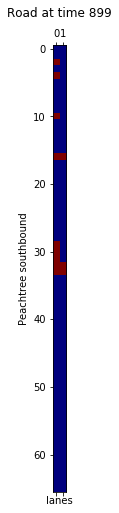

In [19]:
run_sim(900, print_stats=True)

### Run Monte Carlo Simulations

In [20]:
def run_monte_carlo_sims(num_trials_p=20, num_iterations=900, slow_traffic=False):
    
    times = []
    num_cars = []
    for _ in range(num_trials_p):
        run_cars, run_time = run_sim(num_iterations, slow_traffic=slow_traffic)
        times.append(run_time)
        num_cars.append(run_cars)
    
    print('Across {} trials got following stats:'.format(num_trials_p))
    print('\t Time: {}'.format(np.average(times)))
    print('\t # Cars: {}'.format(np.average(num_cars)))
    return times, num_cars

In [21]:
NUM_TRIALS = 50

iterations_l = [900, 1800, 3600, 9000]

t_mat = []
c_mat = []
for iter_length in iterations_l:
    mc_t, mc_c = run_monte_carlo_sims(NUM_TRIALS, num_iterations=iter_length)
    t_mat.append(mc_t)
    c_mat.append(mc_c)


Across 50 trials got following stats:
	 Time: 81.17700825423596
	 # Cars: 170.4
Across 50 trials got following stats:
	 Time: 83.93576885006098
	 # Cars: 339.02
Across 50 trials got following stats:
	 Time: 83.57919561189024
	 # Cars: 660.36
Across 50 trials got following stats:
	 Time: 83.24719905656913
	 # Cars: 1698.54


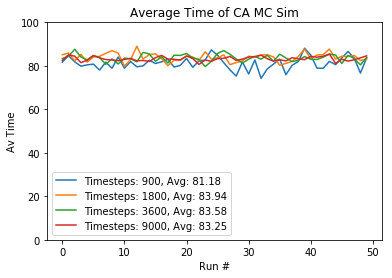

In [22]:
# Plot time
plot.xlabel('Run #')
plot.ylabel('Av Time')
plot.title('Average Time of CA MC Sim')

lab = []

for v, itr_l in zip(t_mat, iterations_l):
    l, = plot.plot(range(NUM_TRIALS), v, label="Timesteps: {}, Avg: {:.2f}".format(itr_l, np.average(v)))
    lab.append(l)
    
plot.legend(handles=lab)
plot.ylim(bottom=0, top=100)
plot.show()

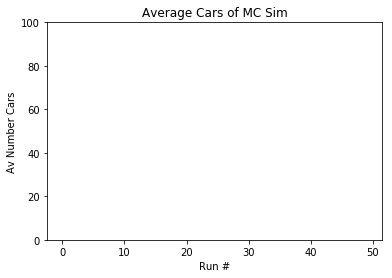

In [23]:
# Plot Cars

plot.xlabel('Run #')
plot.ylabel('Av Number Cars')
plot.title('Average Cars of MC Sim')
plot.plot(range(NUM_TRIALS), mc_c)
plot.ylim(bottom=0, top=100)
plot.show()

In [24]:

iterations_l = [50, 100, 1000]

t_mat = []
c_mat = []
for iter_length in iterations_l:
    mc_t, mc_c = run_monte_carlo_sims(num_trials_p=iter_length)
    t_mat.append(mc_t)
    c_mat.append(mc_c)



Across 50 trials got following stats:
	 Time: 80.7737081030872
	 # Cars: 169.2
Across 100 trials got following stats:
	 Time: 81.51583691790205
	 # Cars: 169.09
Across 1000 trials got following stats:
	 Time: 81.26145536745933
	 # Cars: 168.018


In [25]:
t_mat_avg = [np.average(x) for x in t_mat]

In [26]:
t_mat_avg

[80.7737081030872, 81.51583691790205, 81.26145536745933]

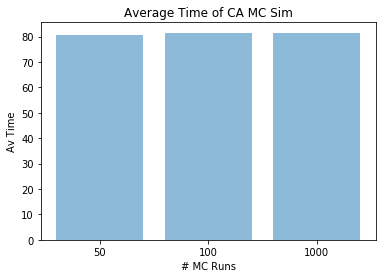

In [27]:
plot.xlabel('# MC Runs')
plot.ylabel('Av Time')
plot.title('Average Time of CA MC Sim')

plot.bar(range(len(t_mat_avg)), t_mat_avg , align='center', alpha=0.5)
plot.xticks(range(len(t_mat_avg)), iterations_l)
 
plot.show()

In [28]:
mc_times_new, mc_num_cars_new = run_monte_carlo_sims(num_trials_p=100, num_iterations=900)

Across 100 trials got following stats:
	 Time: 81.51383995800214
	 # Cars: 170.04


In [29]:
len(mc_times_new)

100

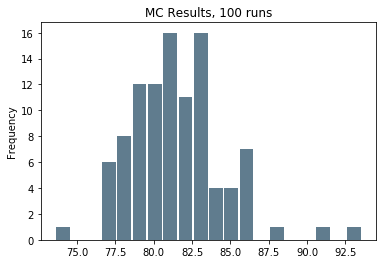

In [30]:
import pandas as pd
times = pd.Series(mc_times_new)
times.plot.hist(grid=False, bins=20, rwidth=0.9, color='#607c8e',title='MC Results, {} runs'.format(times.shape[0]))

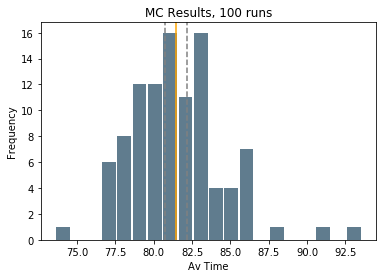

In [31]:
plot.xlabel('Av Time')
plot.ylabel('Frequency')
plot.title('MC Results, {} runs'.format(times.shape[0]))
plot.hist(mc_times_new, bins=20, rwidth=0.9, color='#607c8e')
# lower bound, mean, upper bound CI
plot.axvline(x=80.71542368452617, linestyle="dashed", color="grey")
plot.axvline(x=81.44053808126203, linestyle="solid", color="orange")
plot.axvline(x=82.1656524779979, linestyle="dashed", color="grey")


#### Compare fast and slow

In [32]:
t_normal, _ = run_monte_carlo_sims(num_trials_p=100, num_iterations=900, slow_traffic=False)
t_slow, _ = run_monte_carlo_sims(num_trials_p=100, num_iterations=900, slow_traffic=True)

Across 100 trials got following stats:
	 Time: 81.69866021168312
	 # Cars: 171.24
Across 100 trials got following stats:
	 Time: 79.0197075695602
	 # Cars: 96.5


([<matplotlib.axis.XTick at 0x11db85470>,
 <a list of 2 Text xticklabel objects>)

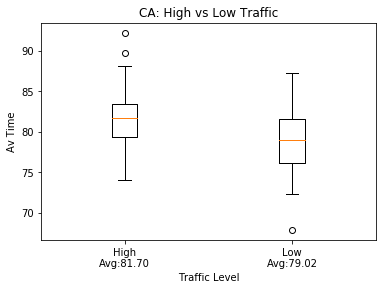

In [33]:
plot.xlabel('Traffic Level')
plot.ylabel('Av Time')
plot.title('CA: High vs Low Traffic')

plot.boxplot([t_normal, t_slow])
plot.xticks([1, 2], ['High\nAvg:{:.2f}'.format(np.average(t_normal)), 'Low\nAvg:{:.2f}'.format(np.average(t_slow))])


In [34]:
mc_times_new

[85.94736842105263,
 83.48387096774194,
 81.01190476190476,
 86.20987654320987,
 84.69642857142857,
 80.23497267759562,
 76.98235294117647,
 86.25625,
 76.62585034013605,
 82.55737704918033,
 84.39080459770115,
 84.23926380368098,
 86.12820512820512,
 80.20645161290322,
 80.0952380952381,
 82.14189189189189,
 80.88023952095809,
 84.0,
 84.83435582822086,
 82.77707006369427,
 78.26415094339623,
 86.05780346820809,
 78.89808917197452,
 80.92817679558011,
 81.18238993710692,
 93.53448275862068,
 80.97241379310344,
 83.42857142857143,
 73.59166666666667,
 83.21264367816092,
 79.57692307692308,
 82.42857142857143,
 91.19540229885058,
 79.19553072625699,
 82.15151515151516,
 82.18181818181819,
 79.86764705882354,
 83.49738219895288,
 76.81045751633987,
 82.64245810055866,
 80.91764705882353,
 77.9578313253012,
 79.58441558441558,
 83.4054054054054,
 80.83333333333333,
 78.26351351351352,
 79.66489361702128,
 78.16091954022988,
 78.98882681564245,
 85.81142857142858,
 78.64444444444445,
 79.8

In [35]:
def mean_confidence_interval(data, confidence=0.99):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), ss.sem(a)
    h = se * ss.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


In [36]:
mean_confidence_interval(mc_times_new)

(81.51383995800214, 80.71089357269224, 82.31678634331203)

In [37]:
# Wait times for high traffic
highWaits = mc_times_new
high_meanWait = sum(highWaits) / float(len(highWaits))
ttest1_samp_res = ss.ttest_1samp(a=highWaits, popmean=high_meanWait)
print("High ttest1_samp_res", ttest1_samp_res)
print("High mean wait", high_meanWait)

High ttest1_samp_res Ttest_1sampResult(statistic=4.648313641700826e-14, pvalue=0.999999999999963)
High mean wait 81.51383995800212
